# Exploring industry returns in the Fama-French data-set

The [49 Industry Portfolios](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_49_ind_port.html) data-set has a series of daily returns of 49 different industry types. Here, we look at some of their statistical properties.

The documentation for the Fama-French data-set can be found [here](https://plutopy.readthedocs.io/en/latest/FamaFrench.html) and [here](https://shyams80.github.io/plutoR/docs/reference/FamaFrench-class.html)

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(lubridate)
library(reshape2)
library(PerformanceAnalytics)
library(ggrepel)
library(tbl2xts)

options("scipen"=999)
options(stringsAsFactors = FALSE)

source("config.R")
source("goofy/plot.common.R")

#initialize
famaFrench <- FamaFrench()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘lubridate’

The following object is masked from ‘package:b

In [2]:
startDt <- as.Date("1990-01-01")

#value (market-cap) weighted
valueWtd <- famaFrench$Industry49Daily() %>%
    filter(RET_TYPE == 'AVWRD' & TIME_STAMP >= startDt) %>%
    mutate(R = RET/100) %>%
    select(DATE = TIME_STAMP, KEY_ID, R) %>%
    collect() %>% 
    # the KEY_ID column has industry id's
    # we want them as column names
    mutate(group=1) %>%
    spread(KEY_ID, R) %>%
    select(-group) %>%
    tbl_xts()

#equal weighted
equalWtd <- famaFrench$Industry49Daily() %>%
    filter(RET_TYPE == 'AEWRD' & TIME_STAMP >= startDt) %>%
    mutate(R = RET/100) %>%
    select(DATE = TIME_STAMP, KEY_ID, R) %>%
    collect() %>% 
    # the KEY_ID column has industry id's
    # we want them as column names
    mutate(group=1) %>%
    spread(KEY_ID, R) %>%
    select(-group) %>%
    tbl_xts()

In [3]:
lookbackDays <- 220 * 5

rrValueWtd <- rollapply(valueWtd, lookbackDays, Return.cumulative, by.column = F)
rrEqualWtd <- rollapply(equalWtd, lookbackDays, Return.cumulative, by.column = F)

rrValueWtd <- na.omit(rrValueWtd)
rrEqualWtd <- na.omit(rrEqualWtd)

names(rrValueWtd) <- names(valueWtd)
names(rrEqualWtd) <- names(equalWtd)

In [4]:
applyFnDf <- function(dframe, appFn){
    temp <- apply(dframe, 2, appFn)
    temp <- data.frame(temp)
    temp <- cbind(temp, row.names(temp))
    colnames(temp) <- c(as.character(substitute(appFn)), 'I')
    return(temp)
}

In [5]:
cumValueWtd <- applyFnDf(valueWtd, Return.cumulative)
cumEqualWtd <- applyFnDf(equalWtd, Return.cumulative)

minValWtd <- applyFnDf(rrValueWtd, min)
minEqlWtd <- applyFnDf(rrEqualWtd, min)

maxValWtd <- applyFnDf(rrValueWtd, max)
maxEqlWtd <- applyFnDf(rrEqualWtd, max)

sdValWtd <- applyFnDf(rrValueWtd, sd)
sdEqlWtd <- applyFnDf(rrEqualWtd, sd)

statsValDf <- minValWtd %>%
    inner_join(maxValWtd) %>%
    inner_join(sdValWtd) %>%
    inner_join(cumValueWtd)

statsEqlDf <- minEqlWtd %>%
    inner_join(maxEqlWtd) %>%
    inner_join(sdEqlWtd) %>%
    inner_join(cumEqualWtd)

print("Value weighted low sd, sorted by returns")
valLowSd <- statsValDf %>% 
    top_n(5, wt=-sd) %>%
    arrange(desc(`Return.cumulative`)) %>%
    select(I) %>%
    as.vector()
print(valLowSd)

print("Equal weighted low sd, sorted by returns")
eqlLowSd <- statsEqlDf %>% 
    top_n(5, wt=-sd) %>%
    arrange(desc(`Return.cumulative`)) %>%
    select(I) %>%
    as.vector()
print(eqlLowSd)

print("Value weighted high returns")
valRet <- statsValDf %>% 
    top_n(5, wt=`Return.cumulative`) %>%
    select(I) %>%
    as.vector()
print(valRet)

print("Equal weighted high returns")
eqlRet <- statsEqlDf %>% 
    top_n(5, wt=`Return.cumulative`) %>%
    select(I) %>%
    as.vector()
print(eqlRet)


Joining, by = "I"
Joining, by = "I"
Joining, by = "I"
Joining, by = "I"
Joining, by = "I"
Joining, by = "I"


[1] "Value weighted low sd, sorted by returns"
      I
1 TRANS
2  FOOD
3  UTIL
4 WHLSL
5 PAPER
[1] "Equal weighted low sd, sorted by returns"
      I
1 SMOKE
2  BEER
3  FOOD
4 BOXES
5  UTIL
[1] "Value weighted high returns"
      I
1  AERO
2 ELCEQ
3  GUNS
4 MEDEQ
5 SOFTW
[1] "Equal weighted high returns"
      I
1 CHIPS
2  HLTH
3 LABEQ
4 MEDEQ
5 SOFTW


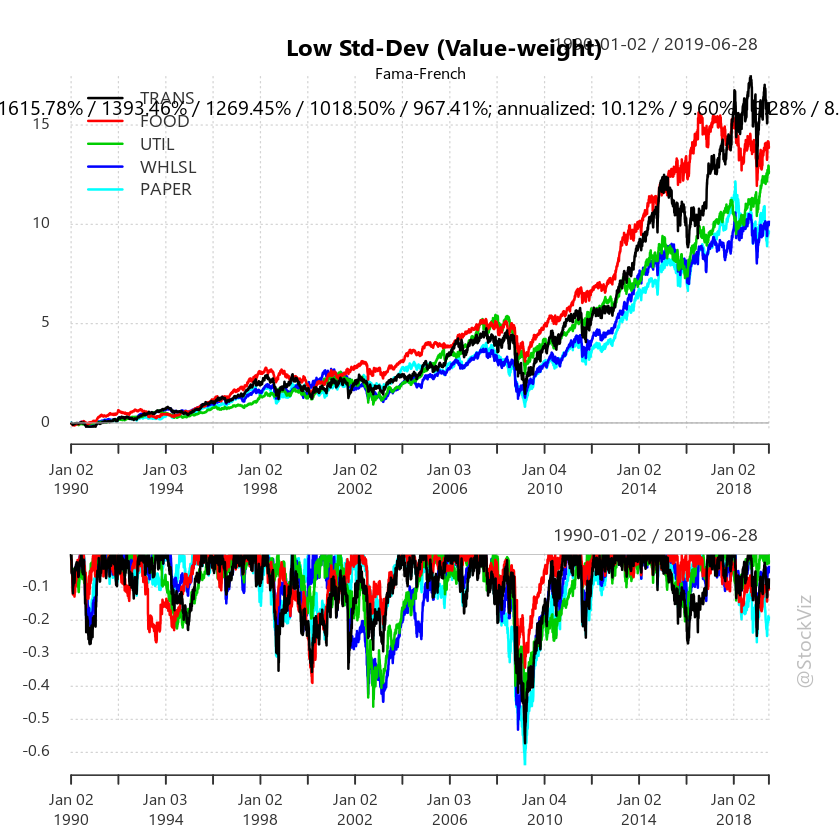

In [6]:
Common.PlotCumReturns(valueWtd[, valLowSd$I], "Low Std-Dev (Value-weight)", "Fama-French")

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)